In [65]:
## This will connect to a girder client, as well as a local Mongo instance and create/load the data
## needed to generate a faceted search view
import pymongo
import girder_client
import json, os, sys
from pprint import pprint
import girder_utils
from IPython.display import Image
%matplotlib inline
DSA_BaseURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'

In [60]:
localMongo = pymongo.MongoClient('localhost',27017)  # connects to mongo database on my laptop
Fox_Facets_DB = localMongo['FOX_faceted_search']
## This is a connnection to the faceted_search database that was created when
# I loaded some test data
fsTestDB  = localMongo['faceted_search'] 

In [15]:
## Create a girder client so I can grab some test images and metadata
gc = girder_client.GirderClient(apiUrl="http://candygram.neurology.emory.edu:8080/api/v1/")

In [19]:
## Find the UID for the FoxData Collection
Fox_UID = ""
for c in gc.listCollection():
    if 'FOX' in c['name']:
        print c
        Fox_UID = c['_id'] 
## If there's more than one collection with the word FOX in it, update the filter above

{u'size': 4097455337662, u'updated': u'2017-07-05T15:41:39.130000+00:00', u'publicFlags': [], u'description': u'', u'created': u'2017-07-05T15:41:39.130000+00:00', u'public': True, u'_id': u'595d08b392ca9a000d0748df', u'_modelType': u'collection', u'_accessLevel': 0, u'name': u'FOX_DATA'}


In [28]:
## Get all the slides in this collection using the recursive function in girder_utils
TopLevelFolders = gc.listFolder(Fox_UID,parentFolderType='collection')

FoxSlideDict = {}  ## I am creating a dict where the top level key is the folder name, and then
## below that are slides in that folder

for tlf in TopLevelFolders:
    SlidesInFolder = girder_utils.recurseGetItems(gc,tlf['_id'])
    print "Retrieving slides in",tlf['name'],";", len(SlidesInFolder),"files are in the current folder"
    FoxSlideDict[tlf['name']] = SlidesInFolder

Retrieving slides in 2017-05-12 ; 53 files are in the current folder
Retrieving slides in 2017-05-13 ; 6 files are in the current folder
Retrieving slides in 2017-05-15 ; 106 files are in the current folder
Retrieving slides in 2017-06-15 ; 84 files are in the current folder
Retrieving slides in 2017-06-20 ; 70 files are in the current folder
Retrieving slides in 2017-06-21 ; 1 files are in the current folder
Retrieving slides in 2017-06-22 ; 25 files are in the current folder
Retrieving slides in 2017-06-23 ; 390 files are in the current folder
Retrieving slides in 2017-06-24 ; 166 files are in the current folder
Retrieving slides in 2017-06-25 ; 39 files are in the current folder
Retrieving slides in 2017-06-26 ; 175 files are in the current folder
Retrieving slides in 2017-06-27 ; 146 files are in the current folder
Retrieving slides in 2017-07-14 ; 238 files are in the current folder
Retrieving slides in 2017-07-17 ; 24 files are in the current folder
Retrieving slides in CuratedFo

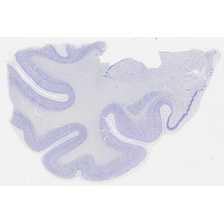

In [70]:
sampleSlide =  FoxSlideDict['2017-05-12'][0]
## We now need a couple of things.. most importantly a URL to view the thumbnail
thumbWidth = thumbHeight = 224
curImageThumbUrl = '/item/%s/tiles/thumbnail?width=%s&height=%s&fill=white' % (sampleSlide['_id'], thumbWidth, thumbHeight)
curImage = gc.get(curImageThumbUrl,  jsonResp=False)

Image(sampImageUrl.content)

In [ ]:
## lets try and directly load data into our facet_images collection

In [56]:
sampleTestRec = fsTestDB.facet_images.find_one()
## This pulls a single entry from our testDB so I can know the format I need for creating a new document
sampleTestRec.keys()
print fsTestDB.collection_names()

[u'servicedatas', u'system.indexes', u'sessions', u'facet_images', u'facet_filters']


In [75]:
## Let's try and create and then insert a document into our faceted search table
clearCurrentData = True
mongoDataToLoad = []


for tlf in FoxSlideDict:

    for sld in FoxSlideDict[tlf][:5]:
        thumbWidth = thumbHeight = 224  ## Probably should make this configurable directly in the UI/app itself
        facetSync_version = '0.1'
        slideData = sld
        slideUrl =  DSA_BaseURL + 'item/%s/tiles/thumbnail?width=%s&height=%s&fill=white' % (sld['_id'], thumbWidth, thumbHeight)
        facetSet = {}
        extract(slideData, facetSet)
        #Let's inject some additional metadata
        ## To do--- add "ignore" keys to the extract function as some of the stuff that I am currently indexing
        ## is not in any way useful

        slideData['largeImage'] = { 'src': slideUrl}
        slideData['rootFolder'] = tlf

        facetRecord = {'filesrc': slideUrl, 'data': slideData, '__v': facetSync_version, 'facets': facetSet, 'largeImage':  {'src': slideUrl}}

        mongoDataToLoad.append(facetRecord)

print "Loading %d records into mongo facet collection" % len(mongoDataToLoad)

if clearCurrentData:
    Fox_Facets_DB['facet_images'].remove({}); #Empty the collection
      
Fox_Facets_DB['facet_images'].insert_many(mongoDataToLoad)
## Add in a post request to hit the local API and refresh the data

###http://localhost:8000/api/facets/updateCache

Loading 76 records into mongo facet collection


/home/dagutman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.


In [71]:
Fox_Facets_DB['facet_images'].remove({});

/home/dagutman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  """Entry point for launching an IPython kernel.


In [30]:
def extract(dict_in, dict_out, keysToPrune = False):
    
    
    for key, value in dict_in.iteritems():
        if isinstance(value, dict): # If value itself is dictionary
            ### Need to update all the keys in value to include the key and insert a hash
            newD = {}
            for k,v in value.iteritems():
                ### Need to parse null values
                if isinstance(v,unicode):  #                 if ( v.isinstance('string') ):
                    if v=="":
                        v= "no value"
                newD[key+'|'+k] = v
            value = newD
            extract(value, dict_out)
        else:  #         elif isinstance(value, unicode):
            # Write to dict_out
            if value=="":
                value= "no value"
            dict_out[key] = value
    facetList = []
    for k,v in dict_out.iteritems():
        facetList.append( {'id': k, 'value': v, 'name': k.split('|')[-1]})
    ### The FacetList is actually a list 
    return dict_out, facetList